<a id='top'></a>
# Fixed-point filtering

This lecture gives basics of fixed-point filtering.  The topics covered will be :

<ol>
<li> Fixed point and floating point representations are assumed to be known, see for example [Wikipedia - Fixed-point arithmetic](https://en.wikipedia.org/wiki/Fixed-point_arithmetic)
<li> [Reminder on analog - discrete - digital signals](#quantization)
<li> [Model of the quantization process](#qmodel) - [Linear quantization](#qlinear) -
  [Quantization Error](#qerror)
<li> [Quantization effects on FIR filters](#fir) - [quantization model of multipliers](#roundoffmodel)
<li> [Quantization effects on IIR filters](#iircoeff) - [effect of multipliers](#iirmult)
</ol>


<a id='quantization'></a>

## Quantization


[Digital signal processors](https://en.wikipedia.org/wiki/Digital_signal_processor) and general purpose processors can only perform arithmetic operations within a limited number range. So far we considered discrete signals with continuous amplitude values. These cannot be handled by processors in a straightforward manner. [Quantization](https://en.wikipedia.org/wiki/Quantization_%28signal_processing%29) is the process of mapping a continuous amplitude to a countable set of amplitude values. This refers also to the *requantization* of a signal from a large set of countable amplitude values to a smaller set. Scalar quantization is an instantaneous and memoryless operation. It can be applied to the continuous amplitude signal, also referred to as *analog signal* or to the (time-)discrete signal. The quantized discrete signal is termed as *digital signal*. The connections between the different domains are illustrated in the following.

![Interrelations between analog, discrete and digital signals](analog_discrete_digital.png)

<a id='qmodel'></a> [go to top](#top)

### Model of the Quantization Process

In order to discuss the effects of quantizing a continuous amplitude signal, a mathematical model of the quantization process is required. We restrict our considerations to a discrete real-valued signal $x[k]$. The following mapping is used in order to quantize the continuous amplitude signal $x[k]$

\begin{equation}
x_Q[k] = g( \; \lfloor \, f(x[k]) \, \rfloor \; )
\end{equation}

where $g(\cdot)$ and $f(\cdot)$ denote real-valued mapping functions, and $\lfloor \cdot \rfloor$ a rounding operation. The quantization process can be split into two stages

1. **Forward quantization**
    The mapping $f(x[k])$ maps the signal $x[k]$ such that it is suitable for the rounding operation. This may be a scaling of the signal or a non-linear mapping. The result of the rounding operation is an integer number $\lfloor \, f(x[k]) \, \rfloor \in \mathbb{Z}$, which is termed as *quantization index*.
    
2. **Inverse quantization**
    The mapping $g(\cdot)$, maps the quantization index to the quantized value $x_Q[k]$ such that it constitutes an approximation of $x[k]$. This may be a simple scaling or non-linear operation.

The quantization error (quantization noise) $e[k]$ is defined as

\begin{equation}
e[k] = x_Q[k] - x[k]
\end{equation}

Rearranging yields that the quantization process can be modeled by adding the quantization error to the discrete signal

![Model of the quantization process](model_quantization.png)

#### Example - Quantization of a sine signal

In order to illustrate the introduced model, the quantization of one period of a sine signal is considered

\begin{equation}
x[k] = \sin[\Omega_0 k]
\end{equation}

using 

\begin{align}
f(x[k]) &= 3 \cdot x[k] \\
i &= \lfloor \, f(x[k]) \, \rfloor \\
g(i) &= \frac{1}{3} \cdot i
\end{align}

where $\lfloor \cdot \rfloor$ denotes the [nearest integer function](https://en.wikipedia.org/wiki/Nearest_integer_function) and $i$ the quantization index. The quantized signal is then given as

\begin{equation}
x_Q[k] = \frac{1}{3} \cdot \lfloor \, 3 \cdot \sin[\Omega_0 k] \, \rfloor
\end{equation}

The discrete signals are not shown by stem plots for ease of illustration.

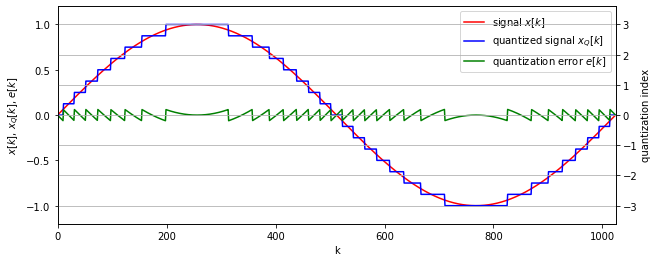

In [8]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

N = 1024  # length of signal
w=8
# generate signal
x = np.sin(2*np.pi/N * np.arange(N))
# quantize signal
xi = np.round(w * x)
xQ = 1/w * xi
e = xQ - x

# plot (quantized) signals
fig, ax1 = plt.subplots(figsize=(10,4))
ax2 = ax1.twinx()

ax1.plot(x, 'r', label=r'signal $x[k]$')
ax1.plot(xQ, 'b', label=r'quantized signal $x_Q[k]$')
ax1.plot(e, 'g', label=r'quantization error $e[k]$')
ax1.set_xlabel('k')
ax1.set_ylabel(r'$x[k]$, $x_Q[k]$, $e[k]$')
ax1.axis([0, N, -1.2, 1.2])
ax1.legend()

ax2.set_ylim([-3.6, 3.6])
ax2.set_ylabel('quantization index')
ax2.grid()

<a id='qlinear'></a> [go to top](#top)
## Characteristic of a Linear Uniform Quantizer

The characteristics of a quantizer depend on the mapping functions $f(\cdot)$, $g(\cdot)$ and the rounding operation $\lfloor \cdot \rfloor$ introduced in the [previous section](introduction.ipynb). A linear quantizer bases on linear mapping functions $f(\cdot)$ and $g(\cdot)$. A uniform quantizer splits the mapped input signal into quantization steps of equal size. Quantizers can be described by their nonlinear in-/output characteristic $x_Q[k] = \mathcal{Q} \{ x[k] \}$, where $\mathcal{Q} \{ \cdot \}$ denotes the quantization process. For linear uniform quantization it is common to differentiate between two characteristic curves, the so called mid-tread and mid-rise. Both are introduced in the following.

### Mid-Tread Characteristic Curve

The in-/output relation of the mid-tread quantizer is given as

\begin{equation}
x_Q[k] = Q \cdot \underbrace{\left\lfloor \frac{x[k]}{Q} + \frac{1}{2} \right\rfloor}_{index}
\end{equation}

where $Q$ denotes the constant quantization step size and $\lfloor \cdot \rfloor$ the [floor function](https://en.wikipedia.org/wiki/Floor_and_ceiling_functions) which maps a real number to the largest integer not greater than its argument. Without restricting $x[k]$ in amplitude, the resulting quantization indexes are [countable infinite](https://en.wikipedia.org/wiki/Countable_set). For a finite number of quantization indexes, the input signal has to be restricted to a minimal/maximal amplitude $x_\text{min} < x[k] < x_\text{max}$ before quantization. The resulting quantization characteristic of a linear uniform mid-tread quantizer is shown below

![Characteristic of a linear uniform mid-tread quantizer](mid_tread_characteristic.png)

The term mid-tread is due to the fact that small values $|x[k]| < \frac{Q}{2}$ are mapped to zero.

#### Example - Mid-tread quantization of a sine signal

The quantization of one period of a sine signal $x[k] = A \cdot \sin[\Omega_0\,k]$ by a mid-tread quantizer is simulated. $A$ denotes the amplitude of the signal, $x_\text{min} = -1$ and $x_\text{max} = 1$ are the smallest and largest output values of the quantizer, respectively.

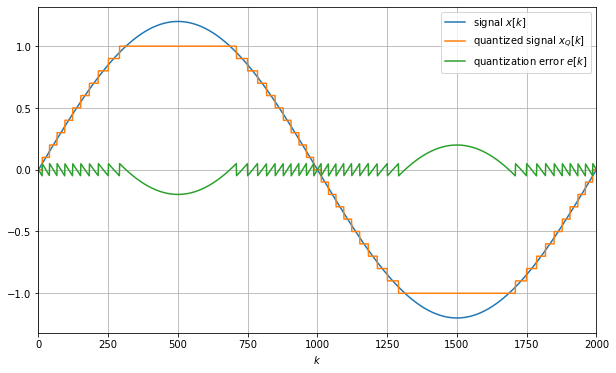

In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

A = 1.2  # amplitude of signal
Q = 1/10  # quantization stepsize
N = 2000  # number of samples

def uniform_midtread_quantizer(x, Q):
    # limiter
    x = np.copy(x)
    idx = np.where(np.abs(x) >= 1)
    x[idx] = np.sign(x[idx])
    # linear uniform quantization
    xQ = Q * np.floor(x/Q + 1/2)
    
    return xQ

def plot_signals(x, xQ):
    e = xQ - x
    plt.figure(figsize=(10,6))
    plt.plot(x, label=r'signal $x[k]$')
    plt.plot(xQ, label=r'quantized signal $x_Q[k]$')
    plt.plot(e, label=r'quantization error $e[k]$')
    plt.xlabel(r'$k$')
    plt.axis([0, N, -1.1*A, 1.1*A])
    plt.legend()
    plt.grid()

# generate signal
x = A * np.sin(2*np.pi/N * np.arange(N))
# quantize signal
xQ = uniform_midtread_quantizer(x, Q)
# plot signals
plot_signals(x, xQ)

**Exercise**

* Change the quantization stepsize `Q` and the amplitude `A` of the signal. Which effect does this have on the quantization error?

Solution: The smaller the quantization step size, the smaller the quantization error is for $|x[k]| < 1$. Note, the quantization error is not bounded for $|x[k]| > 1$ due to the clipping of the signal $x[k]$.

### Mid-Rise Characteristic Curve

The in-/output relation of the mid-rise quantizer is given as

\begin{equation}
x_Q[k] = Q \cdot \Big( \underbrace{\left\lfloor\frac{ x[k] }{Q}\right\rfloor}_{index}  + \frac{1}{2} \Big)
\end{equation}

where $\lfloor \cdot \rfloor$ denotes the floor function. The quantization characteristic of a linear uniform mid-rise quantizer is illustrated below

![Characteristic of a linear uniform mid-rise quantizer](mid_rise_characteristic.png)

The term mid-rise copes for the fact that $x[k] = 0$ is not mapped to zero. Small positive/negative values around zero are mapped to $\pm \frac{Q}{2}$.

#### Example - Mid-rise quantization of a sine signal

The previous example is now reevaluated using the mid-rise characteristic

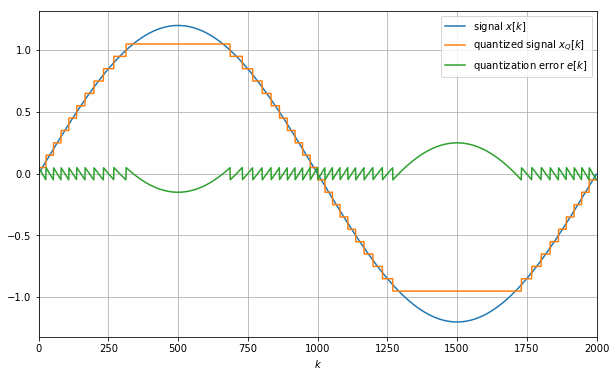

In [3]:
A = 1.2  # amplitude of signal
Q = 1/10  # quantization stepsize
N = 2000  # number of samples

def uniform_midrise_quantizer(x, Q):
    # limiter
    x = np.copy(x)
    idx = np.where(np.abs(x) >= 1)
    x[idx] = np.sign(x[idx])
    # linear uniform quantization
    xQ = Q * (np.floor(x/Q) + .5)
    
    return xQ

# generate signal
x = A * np.sin(2*np.pi/N * np.arange(N))
# quantize signal
xQ = uniform_midrise_quantizer(x, Q)
# plot signals
plot_signals(x, xQ)

<a id='qerror'></a>[go to top](#top)

## Quantization Error of a Linear Uniform Quantizer

As illustrated, quantization results in two different types of distortions. Overload distortions are a consequence of exceeding the minimum/maximum amplitude of the quantizer. Granular distortions are a consequence of the quantization process when no clipping occurs. Various measures are used to quantify the distortions of a quantizer. We limit ourselves to the signal-to-noise ratio as commonly used measure.


### Signal-to-Noise Ratio

A quantizer can be evaluated by its [signal-to-noise ratio](https://en.wikipedia.org/wiki/Signal-to-noise_ratio) (SNR), which is defined as the power of the continuous amplitude signal $x[k]$ divided by the power of the quantization error $e[k]$. Under the assumption that both signals are drawn from a zero-mean wide-sense stationary (WSS) process, the average SNR is given as

\begin{equation}
SNR = 10 \cdot \log_{10} \left( \frac{\sigma_x^2}{\sigma_e^2} \right) \quad \text{ in dB}
\end{equation}

where $\sigma_x^2$ and $\sigma_e^2$ denote the variances of the signals $x[k]$ and $e[k]$, respectively. The SNR quantifies the average impact of the distortions introduced by quantization. The statistical properties of the signal $x[k]$ and the quantization error $e[k]$ are required in order to evaluate the SNR of a quantizer. First, a statistical model for the quantization error is introduced.

### Model for the Quantization Error

In order to derive the statistical properties of the quantization error, the probability density functions (PDFs) of the quantized signal $x_\text{Q}[k]$ and the error $e[k]$, as well as its bivariate PDFs have to be derived. The underlying calculus is quite tedious due to the nonlinear nature of quantization.  The resulting model is summarized in the following. We focus on the non-clipping case $x_\text{min} \leq x[k] < x_\text{max}$ first, hence on granular distortions. Here the quantization error is in general bounded $|e[k]| < \frac{Q}{2}$.

Under the assumption that the input signal has a wide dynamic range compared to the quantization step size $Q$, the quantization error $e[k]$ can be approximated by the following statistical model

1. The quantization error $e[k]$ is not correlated with the input signal $x[k]$

2. The quantization error is white

    $$ \Phi_{ee}(\mathrm{e}^{\,\mathrm{j}\,\Omega}) = \sigma_e^2 $$

3. The probability density function (PDF) of the quantization error is given by the zero-mean uniform distribution

    $$ p_e(\theta) = \frac{1}{Q} \cdot \text{rect} \left( \frac{\theta}{Q} \right) $$

The variance of the quantization error is then derived from its PDF as

\begin{equation}
\sigma_e^2 = \frac{Q^2}{12}
\end{equation}

Let's assume that the quantization index is represented as binary or [fixed-point number](https://en.wikipedia.org/wiki/Fixed-point_arithmetic) with $w$-bits. The common notation for the mid-tread quantizer is that $x_\text{min}$ can be represented exactly. Half of the $2^w$ quantization indexes is used for the negative signal values, the other half for the positive ones including zero. The quantization step is then given as

\begin{equation}
Q = \frac{ |x_\text{min}|}{2^{w-1}} = \frac{ x_\text{max}}{2^{w-1} - 1}
\end{equation}

where $x_\text{max} = |x_\text{min}| - Q$. Introducing the quantization step, the variance of the quantization error can be expressed by the word length $w$ as

\begin{equation}
\sigma_e^2 = \frac{x^2_\text{max}}{3 \cdot 2^{2w}}
\end{equation}

The average power of the quantization error quarters per additional bit spend. Introducing the variance into the definition of the SNR yields

\begin{equation}
\begin{split}
SNR &= 10 \cdot \log_{10} \left( \frac{3 \sigma_x^2}{x^2_\text{max}}  \right) + 10 \cdot \log_{10} \left( 2^{2w} \right) \\
& \approx 10 \cdot \log_{10} \left( \frac{3 \sigma_x^2}{x^2_\text{max}}  \right) + 6.02 w \quad \text{in dB}
\end{split}
\end{equation}

It now can be concluded that the SNR increases approximately by 6 dB per additional bit spend. This is often referred to as the 6 dB per bit rule of thumb for linear uniform quantization. Note, this holds only under the assumptions stated above.

### Uniformly Distributed Signal

A statistical model for the input signal $x[k]$ is required in order to calculate the average SNR of a linear uniform quantizer. For a signal that conforms to a zero-mean uniform distribution and under the assumption $x_\text{max} \gg Q$ its PDF is given as

\begin{equation}
p_x(\theta) = \frac{1}{2 x_\text{max}} \text{rect}\left( \frac{\theta}{2 x_\text{max}} \right)
\end{equation}

Hence, all amplitudes between $-x_\text{max}$ and $x_\text{max}$ occur with the same probability. The variance of the signal is then calculated to

\begin{equation}
\sigma_x^2 = \frac{4 x_\text{max}^2}{12}
\end{equation}

Introducing $\sigma_x^2$ and $\sigma_e^2$ into the definition of the SNR yields

\begin{equation}
SNR = 10 \cdot \log_{10} \left( 2^{2 w} \right) \approx 6.02 \, w \quad \text{in dB}
\end{equation}

The word length $w$ and resulting SNRs for some typical digital signal representations are

| | $w$ | SNR |
|----|:----:|:----:|
| Compact Disc (CD) | 16 bit | 96 dB |
| Digital Video Disc (DVD) | 24 bit | 144 dB |
| Video Signals | 8 bit | 48 dB |

Note that the SNR values hold only if the continuous amplitude signal conforms reasonably well to a uniform PDF and if it uses the full amplitude range of the quantizer. If the latter is not the case this can be considered by introducing the level $0 < A \leq 1$ into above considerations, such that $x_\text{min} \leq \frac{x[k]}{A} < x_\text{max}$. The resulting variance is given as

\begin{equation}
\sigma_x^2 = \frac{4 x_\text{max}^2 A^2}{12}
\end{equation}

introduced into the definition of the SNR yields

\begin{equation}
SNR = 10 \cdot \log_{10} \left( 2^{2 w} \right) + 20 \cdot \log_{10} ( A ) \approx 6.02 \, w + 20 \cdot \log_{10} ( A ) \quad \text{in dB}
\end{equation}

From this it can be concluded that a level of -6 dB is equivalent to a loss of one bit in terms of SNR of the quantized signal.

#### Example - Quantization of a uniformly distributed signal 

In this example the linear uniform quantization of a random signal drawn from a uniform distribution is evaluated. The amplitude range of the quantizer is $x_\text{min} = -1$ and $x_\text{max} = 1 - Q$.

SNR = 48.090272 in dB


C:\Users\roco2\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


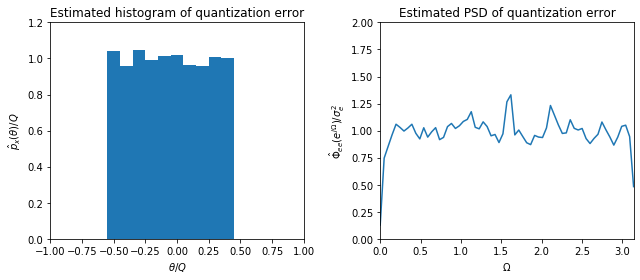

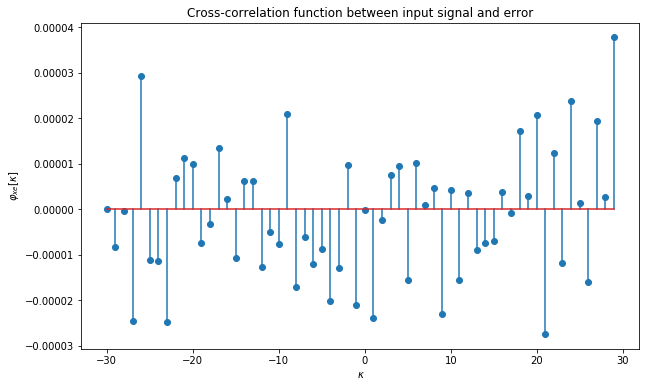

In [10]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig

w = 8  # wordlength of the quantized signal
xmin = -1  # mimimum amplitude of input signal
N = 8192  # number of samples
K = 30  # maximum lag for cross-correlation


def uniform_midtread_quantizer(x, Q):
    # limiter
    x = np.copy(x)
    idx = np.where(x <= -1)
    x[idx] = -1
    idx = np.where(x > 1 - Q)
    x[idx] = 1 - Q
    # linear uniform quantization
    xQ = Q * np.floor(x/Q + 1/2)
    
    return xQ

def analyze_quantizer(x, e):
    # estimated PDF of error signal
    pe, bins = np.histogram(e, bins=20, density=True, range=(-Q, Q))
    # estimate cross-correlation between input and error
    ccf = 1/len(x) * np.correlate(x, e, mode='full')
    # estimate PSD of error signal
    nf, Pee = sig.welch(e, nperseg=128)
    # estimate SNR
    SNR = 10*np.log10((np.var(x)/np.var(e)))
    print('SNR = %f in dB' %SNR)

    # plot statistical properties of error signal
    plt.figure(figsize=(9,4))

    plt.subplot(121)
    plt.bar(bins[:-1]/Q, pe*Q, width = 2/len(pe))
    plt.title('Estimated histogram of quantization error')
    plt.xlabel(r'$\theta / Q$')
    plt.ylabel(r'$\hat{p}_x(\theta) / Q$')
    plt.axis([-1, 1, 0, 1.2])

    plt.subplot(122)
    plt.plot(nf*2*np.pi, Pee*6/Q**2)
    plt.title('Estimated PSD of quantization error')
    plt.xlabel(r'$\Omega$')
    plt.ylabel(r'$\hat{\Phi}_{ee}(e^{j \Omega}) / \sigma_e^2$')
    plt.axis([0, np.pi, 0, 2])
    plt.tight_layout()
    
    plt.figure(figsize=(10,6))
    ccf = ccf[N-K-1:N+K-1]
    kappa = np.arange(-len(ccf)//2,len(ccf)//2)
    plt.stem(kappa, ccf)
    plt.title('Cross-correlation function between input signal and error')
    plt.xlabel(r'$\kappa$')
    plt.ylabel(r'$\varphi_{xe}[\kappa]$')


# quantization step
Q = 1/(2**(w-1))
# compute input signal
np.random.seed(1)
x = np.random.uniform(size=N, low=xmin, high=(-xmin-Q))
# quantize signal
xQ = uniform_midtread_quantizer(x, Q)
e = xQ - x
# analyze quantizer
analyze_quantizer(x, e)

<a id='fir'></a> [go to top](#top)

## Quantization Effects on F.I.R. filters

Numbers and numerical operations are represented with a finite numerical resolution in digital processors. The same holds for the amplitude values of signals and the algorithmic operations applied to them. Hence, the intended characteristics of a digital filter may deviate in practice due to the finite numerical resolution. The [double-precision floating point representation](https://en.wikipedia.org/wiki/Double-precision_floating-point_format) used in numerical environments like MATLAB or Python/numpy is assumed to be quasi-continuous. This representation serves therefore as reference for the evaluation of quantization effects.

This section investigates the consequences of quantization in non-recursive filters. We first take a look on the quantization of the filter coefficients, followed by the effects caused by a finite numerical resolution of the operations. The realization of non-recursive filters is subject to both effects.

### Quantization of Filter Coefficients

The output signal $y[k]$ of a non-recursive filter with a finite impulse response (FIR) $h[k]$ of length $N$ is given as

\begin{equation}
y[k] = h[k] * x[k] = \sum_{\kappa = 0}^{N-1} h[\kappa] \; x[k - \kappa]
\end{equation}

where $x[k]$ denotes the input signal. The quantized impulse response $h_Q[k]$ (quantized filter coefficients) is yielded by quantizing the impulse response $h[k]$

\begin{equation}
h_Q[k] = \mathcal{Q} \{ h[k] \} = h[k] + e[k]
\end{equation}

where $e[k] = h_Q[k] - h[k]$ denotes the [quantization error](#qerror). Introducing $h_Q[k]$ into above equation and rearranging results in

\begin{equation}
y_Q[k] = \sum_{\kappa = 0}^{N-1} h[\kappa] \; x[k - \kappa] + \sum_{\kappa = 0}^{N-1} e[\kappa] \; x[k - \kappa]
\end{equation}

The input signal $x[k]$ is filtered by the quantization noise $e[k]$ and superimposed to the desired output of the filter. The overall transfer function $H_Q(e^{j \Omega})$ of the filter with quantized filter coefficients is given as

\begin{equation}
H_Q(e^{j \Omega}) = \sum_{k=0}^{N-1} h[k] \; e^{-j \Omega k} + \sum_{k=0}^{N-1} e[k] \; e^{-j \Omega k}  = H(e^{j \Omega}) + E(e^{j \Omega})
\end{equation}

Hence, the quantization of filter coefficients results in a linear distortion of the desired frequency response. To some extent, this distortion can be incorporated into the design of the filter. However, the magnitude of the quantization error $| E(e^{j \Omega}) |$ cannot get arbitrarily small for a finite quantization step $Q$. This limits the achievable attenuation of a digital filter with quantized coefficients. It is therefore important to normalize the filter coefficients $h[k]$ before quantization in order to keep the relative power of the quantization noise small.

#### Example - Effect of coefficient quantization in a lowpass filter

The coefficients of a digital lowpass filter with a cutoff frequency of $\Omega_0 = \frac{\pi}{2}$ are quantized in the following example.

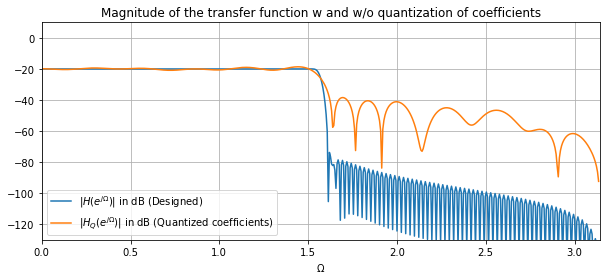

In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig

w = 10  # wordlength of quantized coefficients
A = 0.1  # attenuation of filter coefficients
N = 256//1  # number of coefficients for filter
Q = 1/(2**(w-1))  # quantization stepsize

def uniform_midtread_quantizer(x, Q):
    # limiter
    x = np.copy(x)
    idx = np.where(x <= -1)
    x[idx] = -1
    idx = np.where(x > 1 - Q)
    x[idx] = 1 - Q
    # linear uniform quantization
    xQ = Q * np.floor(x/Q + 1/2)
    
    return xQ

# design lowpass
h = A * sig.firwin(N, .5)
# quantize coefficients
hQ = uniform_midtread_quantizer(h, Q)

# plot frequency response
Om, H = sig.freqz(h)
Om, HQ = sig.freqz(hQ)
Om, E = sig.freqz(hQ-h)

plt.figure(figsize=(10, 4))
plt.plot(Om, 20*np.log10(np.abs(H)), label=r'$| H(e^{j \Omega}) |$ in dB (Designed)')
plt.plot(Om, 20*np.log10(np.abs(HQ)), label=r'$| H_Q(e^{j \Omega}) |$ in dB (Quantized coefficients)')
plt.title('Magnitude of the transfer function w and w/o quantization of coefficients')
plt.xlabel(r'$\Omega$')
plt.axis([0, np.pi, -130, 10])
plt.legend(loc=3)
plt.grid()

**Exercise**

* Change the wordlength `w` of the quantized filter coefficients. How does the magnitude response $| H_Q(e^{j \Omega}) |$ of the quantized filter change?
* Change the attenuation `A` of the filter coefficients. What changes?
* Why does the magnitude response of the quantized filter $| H_Q(e^{j \Omega}) |$ deviate more from the magnitude response of the designed filter $| H(e^{j \Omega}) |$ in the frequency ranges with high attenuation?

Solution: The magnitude response of the quantized filter deviates more from the designed filter the shorter the wordlength `w` is chosen. This is due to the increasing quantization error for shorter wordlengths. The quantization error increases also in comparison to the filter coefficients if their amplitude (attenuation `A`) is small. The deviations from the designed filter are generally higher for high attenuations since the quantization error is additive $H_Q(e^{j \Omega}) = H(e^{j \Omega}) + E(e^{j \Omega})$, as derived above.

### Quantization of Signals and Operations

Besides the quantization of filter coefficients $h[k]$, also the quantization of the signals, state variables and operations has to be considered in a practical implementation of filters. The computation of the output signal $y[k] = h[k] * x[k]$ of a non-recursive filter by convolution involves multiplications and additions. In digital signal processors numbers are often represented in [fixed-point arithmetic](https://en.wikipedia.org/wiki/Fixed-point_arithmetic) using [two's complement](https://en.wikipedia.org/wiki/Two's_complement). When multiplying two numbers with a wordlength of $w$-bits in this representation the result would require $2w$-bits. Hence the result has to be requantized to $w$-bits. The rounding operation in the quantizer is often realized as truncation of the $w$ least significant bits. The resulting quantization error is known as [round-off error](https://en.wikipedia.org/wiki/Round-off_error). The addition of two numbers may fall outside the maximum/minimum values of the representation and may suffer from clipping. Similar considerations hold also for other number representations, like e.g. [floating point](https://en.wikipedia.org/wiki/Floating_point).

As for the [quantization noise](#qmodel), a statistical model for the round-off error in multipliers is used to quantify the average impact of round-off noise in a non-recursive filter.

<a id='roundoffmodel'></a> 
[go to top](#top)

#### Model for round-off errors in multipliers

As outlined above, multipliers require a requantization of the result in order to keep the wordlength constant. The multiplication of a quantized signal $x_Q[k]$ with a quantized factor $a_Q$ can be written as

\begin{equation}
y_Q[k] = \mathcal{Q} \{ a_Q \cdot x_Q[k] \} = a_Q \cdot x_Q[k] + e[k]
\end{equation}

where the round-off error $e[k]$ is defined as

\begin{equation}
e[k] = y_Q[k] - a_Q \cdot x_Q[k]
\end{equation}

This leads to the following model of a multiplier including round-off effects

![Model for round-off noise in a multiplier](roundoff_model.png)

The round-off error can be modeled statistically in the same way as quantization noise [[Zölzer](../index.ipynb#Literature)]. Under the assumption that the average magnitude of $a_Q \cdot x_Q[k]$ is much larger that the quantization step size $Q$, the round-off error $e[k]$ can be approximated by the following statistical model

1. The round-off error $e[k]$ is not correlated with the input signal $x_Q[k]$

2. The round-off error is white

    $$ \Phi_{ee}(\mathrm{e}^{\,\mathrm{j}\,\Omega}) = \sigma_e^2 $$

2. The probability density function (PDF) of the round-off error is given by the zero-mean uniform distribution

    $$ p_e(\theta) = \frac{1}{Q} \cdot \text{rect} \left( \frac{\theta}{Q} \right) $$

The variance (power) of the round-off error is derived from its PDF as

\begin{equation}
\sigma_e^2 = \frac{Q^2}{12}
\end{equation}

#### Round-off noise

Using above model of a multiplier and discarding clipping, a straightforward realization of the convolution with quantized signals would be to requantize after every multiplication 

\begin{equation}
\begin{split}
y_Q[k] &= \sum_{\kappa = 0}^{N-1} \mathcal{Q} \{ h_Q[\kappa] \; x_Q[k - \kappa] \} \\
&= \sum_{\kappa = 0}^{N-1} h_Q[\kappa] \; x_Q[k - \kappa] + e[\kappa] \\ 
&= \left( \sum_{\kappa = 0}^{N-1} h_Q[\kappa] \; x_Q[k - \kappa] \right) + e_\text{tot}[k]
\end{split}
\end{equation}

where $e_\text{tot}[k] = \sum_{\kappa = 0}^{N-1} e[\kappa]$. The round-off errors $e[\kappa]$ for each multiplication are uncorrelated to each other. The overall power of the round-off error is then given as

\begin{equation}
\sigma_{e, \text{tot}}^2 = N \cdot \frac{Q^2}{12}
\end{equation}

Many digital signal processors allow to perform the multiplications and additions in an internal register with double wordlength. In this case, only the result of the convolution sum has to be requantized 

\begin{equation}
y_Q[k] = \mathcal{Q} \left\{ \sum_{\kappa = 0}^{N-1}  h_Q[\kappa] \; x_Q[k - \kappa] \right\} = 
\left( \sum_{\kappa = 0}^{N-1} h_Q[\kappa] \; x_Q[k - \kappa] \right) + e[k]
\end{equation}

and the total power of the round-off noise in this case is

\begin{equation}
\sigma_{e, \text{tot}}^2 = \frac{Q^2}{12}
\end{equation}

It is evident that this realization is favorable due to the lower round-off noise, especially for filters with a large number $N$ of coefficients.

#### Example - Effect of requantization after each multiplication

The following example simulates the round-off noise of a non-recursive filter when requantization is performed after each multiplication. Clipping is not considered. The input signal $x[k]$ is drawn from a [uniform distribution] with $a=-1$ and $b=1-Q$. Both the input signal and filter coefficients are quantized. The output signal $y[k]$ without requantization of the multiplications is computed, as well as the output signal $y_Q[k]$ with requantization. The statistical properties of the round-off noise $e[k] = y_Q[k] - y[k]$ are evaluated.

Power of overall round-off noise is -86.130014 dB
SNR :  90.58338956947574


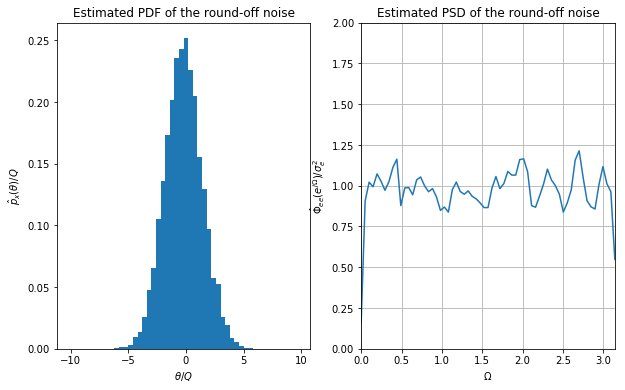

In [16]:
w = 16  # wordlength of quantized coefficients/operations
N = 32  # number of coefficients for filter
L = 8192  # length of input signal
Q = 1/(2**(w-1))  # quantization stepsize


def uniform_midtread_quantizer(x, Q):
    xQ = Q * np.floor(x/Q + 1/2)
    
    return xQ


# random impulse response
h = np.random.uniform(size=N, low=-1, high=1)
hQ = uniform_midtread_quantizer(h, Q)
# input signal
x = np.random.uniform(size=L, low=-1, high=1-Q)
xQ = uniform_midtread_quantizer(x, Q)
# output signal by convolution
y = np.zeros(L+N-1)
yQ = np.zeros(L+N-1)
for k in np.arange(L):
    for kappa in np.arange(N):
        if (k-kappa) >= 0:
            y[k] += hQ[kappa] * xQ[k-kappa]
            yQ[k] += uniform_midtread_quantizer(hQ[kappa] * xQ[k-kappa], Q)

# overall round-off error
e = yQ - y

sy = 10*np.log10(np.mean(y*y))

# estimate power of round-off error
sx = 10*np.log10(np.var(e))
print('Power of overall round-off noise is %f dB' %sx)
print('SNR : ',10*np.log10(np.mean(y*y)/np.var(e)))
# estimated PDF of round-off error
pe, bins = np.histogram(e, bins=50, density=True, range=(-10*Q, 10*Q))
# estimate PSD of round-off error
nf, Pee = sig.welch(e, nperseg=128)


# plot statistical properties of error signal
plt.figure(figsize=(10,6))

plt.subplot(121)
plt.bar(bins[:-1]/Q, pe*Q, width = 20/len(pe))
plt.title('Estimated PDF of the round-off noise')
plt.xlabel(r'$\theta / Q$')
plt.ylabel(r'$\hat{p}_x(\theta) / Q$')
#plt.axis([-1, 1, 0, 1.2])

plt.subplot(122)
plt.plot(nf*2*np.pi, Pee*6/Q**2/N)
plt.title('Estimated PSD of the round-off noise')
plt.xlabel(r'$\Omega$')
plt.ylabel(r'$\hat{\Phi}_{ee}(e^{j \Omega}) / \sigma_e^2$')
plt.axis([0, np.pi, 0, 2])
plt.grid();

<a id='iircoeff'></a> [go to top](#top)
## Quantization effect on I.I.R. filters

### Quantization of Filter Coefficients

The finite numerical resolution of digital number representations has impact on the properties of filters, as already discussed for non-recursive (F.I.R.) filters. The quantization of coefficients, state variables, algebraic operations and signals plays an important role in the design of recursive filters. Compared to non-recursive filters, the impact of quantization is often more prominent due to the feedback. Severe degradations from the desired characteristics and instability are potential consequences of a finite word length in practical implementations.

A recursive filter of order $N \geq 2$ can be decomposed into second-order sections (SOS). Due to the grouping of poles/zeros to filter coefficients with a limited amplitude range, a realization by cascaded SOS is favorable in practice. We therefore limit our investigation of quantization effects to SOS. The transfer function of a SOS is given as

\begin{equation}
H(z) = \frac{b_0 + b_1 z^{-1} + b_2 z^{-2}}{1 + a_1 z^{-1} + a_2 z^{-2}}
\end{equation}

This can be split into a non-recursive part and a recursive part. The quantization effects of non-recursive filters have already been discussed. We therefore focus here on the recursive part given by the transfer function

\begin{equation}
H(z) = \frac{1}{1 + a_1 z^{-1} + a_2 z^{-2}}
\end{equation}

This section investigates the consequences of quantization in recursive filters. As for non-recursive filters, we first take a look at the quantization of filter coefficients. The structure used for the realization of the filter has impact on the quantization effects. We begin with the direct form followed by the coupled form, as example for an alternative structure.

### Direct Form

Above transfer function of the recursive part of a SOS can be rewritten in terms of its complex conjugate poles $z_{\infty}$ and $z_{\infty}^*$ as

\begin{equation}
H(z) = \frac{1}{(z-z_{\infty}) (z-z_{\infty}^*)} = \frac{z^{-2}}{ 1 \underbrace{- 2 r \cos(\varphi)}_{a_1} \; z^{-1} + \underbrace{r^2}_{a_2} \; z^{-2} }
\end{equation}

where $r = |z_{\infty}|$ and $\varphi = \arg \{z_{\infty}\}$ denote the absolute value and phase of the pole $z_{\infty}$, respectively. Let's assume a [linear uniform quantization](#qlinear) of the coefficients $a_1$ and $a_2$ with quantization step $Q$. Discarding clipping, the following relations for the locations of the poles can be found

\begin{align}
r_n &= \sqrt{n \cdot Q} \\
\varphi_{nm} &= \arccos \left( \sqrt{\frac{m^2 Q}{4 n}} \right)
\end{align}
for $n \in \mathbb{N}_0$ and $m \in \mathbb{Z}$. Quantization of the filter coefficients $a_1$ and $a_2$ into a finite number of amplitude values leads to a finite number of pole locations. In the $z$-plane the possible pole locations are given by the intersections of

* circles whose radii $r_n$ are given by $r_n = \sqrt{n \cdot Q}$ with
* equidistant vertical lines which intersect the horizontal axis at $\frac{1}{2} m \cdot Q$.

The finite number of pole locations may lead to deviations from a desired filter characteristic since a desired pole location is moved to the next possible pole location. The filter may even get unstable, when poles are moved outside the unit circle. For illustration, the resulting pole locations for a SOS realized in direct form are computed and plotted.

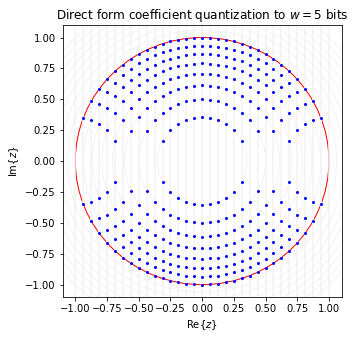

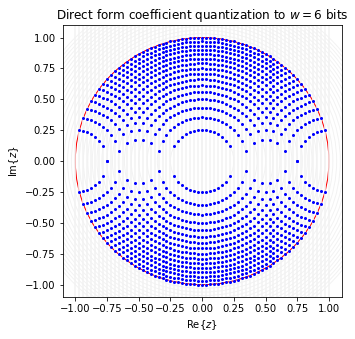

In [11]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import scipy.signal as sig
import itertools


def compute_pole_locations(Q):
    a1 = np.arange(-2, 2+Q, Q)
    a2 = np.arange(0, 1+Q, Q)
    
    p = np.asarray([np.roots([1, n, m]) for (n,m) in itertools.product(a1, a2)])
    p = p[np.imag(p)!=0]

    return p

def plot_pole_locations(p, Q):
    ax = plt.gca()
    for n in np.arange(np.ceil(2/Q)+1):
        circle = Circle((0,0), radius=np.sqrt(n*Q), fill=False, color='black', ls='solid', alpha=0.05)
        ax.add_patch(circle)
        ax.axvline(.5*n*Q, color='0.95')
        ax.axvline(-.5*n*Q, color='0.95')

    unit_circle = Circle((0,0), radius=1, fill=False, color='red', ls='solid')
    ax.add_patch(unit_circle)    

    plt.plot(np.real(p), np.imag(p), 'b.', ms = 4)
    plt.xlabel(r'Re{$z$}')
    plt.ylabel(r'Im{$z$}')
    plt.axis([-1.1, 1.1, -1.1, 1.1])

# compute and plot pole locations
for w in [5,6]:
    Q = 2/(2**(w-1))  # quantization stepsize
    plt.figure(figsize=(5, 5))
    p = compute_pole_locations(Q)
    plot_pole_locations(p, Q)
    plt.title(r'Direct form coefficient quantization to $w=%d$ bits'%w)

### Coupled Form

Besides the quantization step $Q$, the pole distribution depends also on the topology of the filter. In order to gain a different distribution of pole locations after quantization, one has to derive structures where the coefficients of the multipliers are given by other values than the direct form coefficients $a_1$ and $a_2$. 

One of these alternative structures is the coupled form (also known as Gold & Rader structure)

![Coupled form second order section](coupled_form.png)

where $\Re\{z_\infty\} = r \cdot \cos \varphi$ and $\Im\{z_\infty\} = r \cdot \sin \varphi$ denote the real- and imaginary part of the complex pole $z_\infty$, respectively. Analysis of the structure reveals its difference equation as

\begin{align}
w[k] &= x[k] + \Re\{z_\infty\} \, w[k-1] - \Im\{z_\infty\} \, y[k-1] \\
y[k] &= \Im\{z_\infty\} \, w[k-1] + \Re\{z_\infty\} \, y[k-1]
\end{align}

and its transfer function as

\begin{equation}
H(z) = \frac{\Im\{z_\infty\} \; z^{-1}}{ 1 - 2 \Re\{z_\infty\} \; z^{-1} + (\Re\{z_\infty\}^2 + \Im\{z_\infty\}^2) \; z^{-2} }
\end{equation}

Note that the numerator of the transfer function differs from the recursive only SOS given above. However, this can be considered in the design of the transfer function of a general SOS.

The real- and imaginary part of the pole $z_\infty$ occur directly as coefficients for the multipliers in the coupled form. Quantization of these coefficients results therefore in a Cartesian grid of possible pole locations in the $z$-plane. This is illustrated in the following.

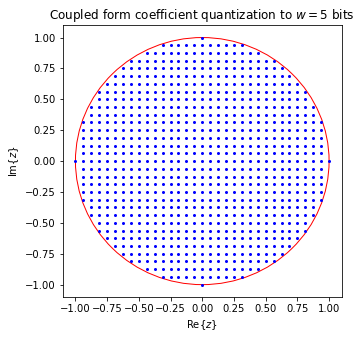

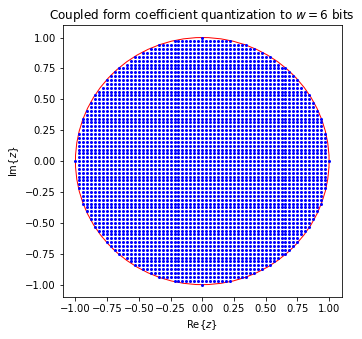

In [8]:
def compute_pole_locations(w):
    Q = 1/(2**(w-1))  # quantization stepsize
    a1 = np.arange(-1, 1+Q, Q)
    a2 = np.arange(-1, 1+Q, Q)
    
    p = np.asarray([n+1j*m for (n,m) in itertools.product(a1, a2) if n**2+m**2 <= 1])

    return p

def plot_pole_locations(p):
    ax = plt.gca()
    
    unit_circle = Circle((0,0), radius=1, fill=False, color='red', ls='solid')
    ax.add_patch(unit_circle)    

    plt.plot(np.real(p), np.imag(p), 'b.', ms = 4)
    plt.xlabel(r'Re{$z$}')
    plt.ylabel(r'Im{$z$}')
    plt.axis([-1.1, 1.1, -1.1, 1.1])

    
# compute and plot pole locations
for w in [5,6]:
    plt.figure(figsize=(5, 5))
    p = compute_pole_locations(w)
    plot_pole_locations(p)
    plt.title(r'Coupled form coefficient quantization to $w=%d$ bits'%w)

### Example - Influence of coefficient quantization

The following example illustrates the effects of coefficient quantization for a recursive [Butterworth filter](https://en.wikipedia.org/wiki/Butterworth_filter) realized in cascaded SOSs in transposed direct form II.

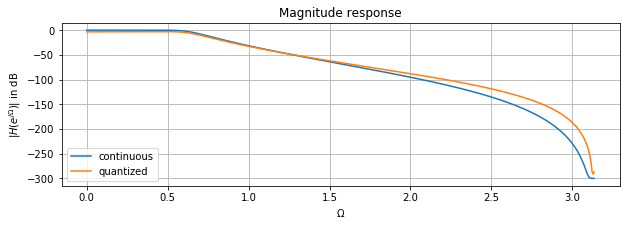

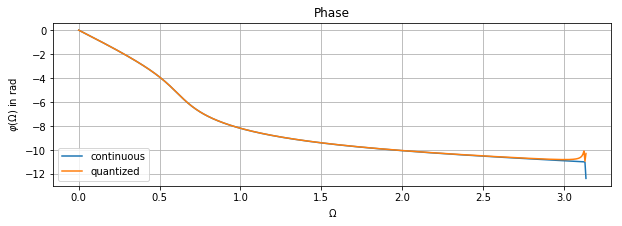

In [9]:
w = 15  # wordlength of filter coefficients
N = 7  # order of filter

def uniform_midtread_quantizer(x, w, xmin=1):
    # quantization step
    Q = xmin/(2**(w-1))
    # limiter
    x = np.copy(x)
    idx = np.where(x <= -xmin)
    x[idx] = -1
    idx = np.where(x > xmin - Q)
    x[idx] = 1 - Q
    # linear uniform quantization
    xQ = Q * np.floor(x/Q + 1/2)
    
    return xQ

# coefficients of recursive filter
b, a = sig.butter(N, 0.2, 'low')
# decomposition into SOS
sos = sig.tf2sos(b, a, pairing='nearest')
sos = sos/np.amax(np.abs(sos))
# quantization of SOS coefficients
sosq = uniform_midtread_quantizer(sos, w, xmin=2)
# compute overall transfer function of (quantized) filter
H = np.ones(512)
Hq = np.ones(512)
for n in range(sos.shape[0]):
    Om, Hn = sig.freqz(sos[n, 0:3], sos[n, 3:6])
    H = H * Hn
    Om, Hn = sig.freqz(sosq[n, 0:3], sosq[n, 3:6])
    Hq = Hq * Hn


# plot magnitude responses
plt.figure(figsize=(10, 3))
plt.plot(Om, 20 * np.log10(abs(H)+1e-15), label='continuous')
plt.plot(Om, 20 * np.log10(abs(Hq)+1e-15), label='quantized')
plt.title('Magnitude response')
plt.xlabel(r'$\Omega$')
plt.ylabel(r'$|H(e^{j \Omega})|$ in dB')
plt.legend(loc=3)
plt.grid()
# plot phase responses
plt.figure(figsize=(10, 3))
plt.plot(Om, np.unwrap(np.angle(H)), label='continuous')
plt.plot(Om, np.unwrap(np.angle(Hq)), label='quantized')
plt.title('Phase')
plt.xlabel(r'$\Omega$')
plt.ylabel(r'$\varphi (\Omega)$ in rad')
plt.legend(loc=3)
plt.grid()

**Exercise**

* Decrease the word length `w` of the filter. What happens? At what word length does the filter become unstable?
* Increase the order `N` of the filter for a fixed word length `w`. What happens?

Solution: The deviations from the continuous (desired) realization of the filter increase with decreasing word length. The filter with order `N=5` becomes unstable for `w = 10`. Increasing the order `N` of the filter for a fixed word length results also in instabilities. Consequently, for a high order filter also a higher word length is required.

<a id='iirmult'></a> [go to top](#top)
### Analysis of Round-Off Errors

Round-off errors are a consequence of reducing the word length after a multiplication. In order to investigate the influence of these errors on a recursive filter, the statistical model for [round-off errors in multipliers](#roundoffmodel) as introduced for non-recursive filters is used. We furthermore neglect clipping. 

The difference equation for the recursive part of a SOS realized in direct form I or II is given as

\begin{equation}
y[k] =  x[k] - a_1 \, y[k-1] - a_2 \, y[k-2]
\end{equation}

where $a_0 = 1$, $a_1$ and $a_2$ denote the coefficients of the recursive part. Introducing the requantization after the multipliers into the difference equation yields the output signal $y_Q[k]$

\begin{equation}
y_Q[k] = x[k] - \mathcal{Q} \{ a_{1} \, y[k-1] \} - \mathcal{Q} \{ a_{2} \, y[k-2] \}
\end{equation}

where $\mathcal{Q} \{ \cdot \}$ denotes the requantizer. Requantization is a non-linear process which results in a requantization error. If the value to be requantized is much larger that the quantization step $Q$, the average statistical properties of this error can be modeled as additive uncorrelated white noise. Introducing the error into above difference equation gives

\begin{equation}
y_Q[k] = x[k] - a_1 \, y[k-1] - e_1[k] - a_2 \, y[k-2] - e_2[k]
\end{equation}

where the two white noise sources $e_1[k]$ and $e_2[k]$ are assumed to be uncorrelated to each other. This difference equation can be split into a set of two difference equations

\begin{align}
y_Q[k] &= y[k] + e[k] \\
y[k] &=  x[k] - a_1 \, y[k-1] - a_2 \, y[k-2] \\
e[k] &= - e_1[k] - e_2[k] - a_1 \, e[k-1] - a_2 \, e[k-2]
\end{align}

The first difference equation computes the desired output signal $y[k]$ as a result of the input signal $x[k]$. The second one the additive error $e[k]$ due to requantization as a result of the requantization error $- (e_1[k] + e_2[k])$ injected into the recursive filter.
The power spectral density (PSD) $\Phi_{ee}(\mathrm{e}^{\,\mathrm{j}\,\Omega})$ of the error $e[k]$ is then given as

\begin{equation}
\Phi_{ee}(\mathrm{e}^{\,\mathrm{j}\,\Omega}) = | H(\mathrm{e}^{\,\mathrm{j}\,\Omega})|^2 \cdot (\Phi_{e_1 e_1}(\mathrm{e}^{\,\mathrm{j}\,\Omega}) + \Phi_{e_2 e_2}(\mathrm{e}^{\,\mathrm{j}\,\Omega}))
\end{equation}

According to the model for the requantization errors, their PSDs are given as $\Phi_{e_1 e_1}(\mathrm{e}^{\,\mathrm{j}\,\Omega}) = \Phi_{e_2 e_2}(\mathrm{e}^{\,\mathrm{j}\,\Omega}) = \frac{Q^2}{12}$. Introducing this together with the transfer function of the SOS yields

\begin{equation}
\Phi_{ee}(\mathrm{e}^{\,\mathrm{j}\,\Omega}) = \left| \frac{1}{1 + a_1 \, \mathrm{e}^{\,-\mathrm{j}\,\Omega} + a_2 \, \mathrm{e}^{\,-\mathrm{j}\,2\,\Omega}} \right|^2 \cdot \frac{Q^2}{6}
\end{equation}

#### Example - Round-off error of a SOS

The following example evaluates the error $e[k] = y_Q[k] - y[k]$ for a SOS which only consists of a recursive part. The desired system response $y[k]$ is computed numerically by floating point operations with double precision, $y_Q[k]$ is computed by applying a uniform midtread quantizer after the multiplications. The system is excited by uniformly distributed white noise. Besides the PSD $\Phi_{ee}(\mathrm{e}^{\,\mathrm{j}\,\Omega})$, the signal-to-noise ratio (SNR) $10 \cdot \log_{10} \left( \frac{\sigma_y^2}{\sigma_e^2} \right)$ in dB of the filter is evaluated.

SNR due to requantization: 45.553969 dB


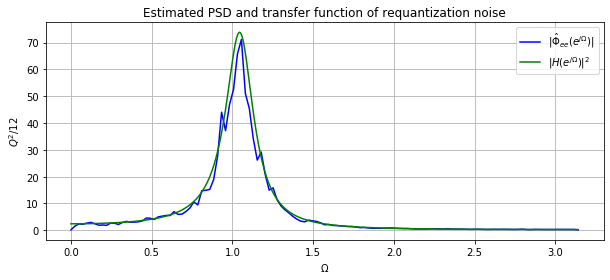

In [11]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig


N = 8192  # length of signals
w = 8  # wordlength for requantization of multiplications


def uniform_midtread_quantizer(x):
    # linear uniform quantization
    xQ = Q * np.floor(x/Q + 1/2)
    
    return xQ


def no_quantizer(x):
    
    return x


def sos_df1(x, a, requantize=None):
    y = np.zeros(len(x)+2)  # initial value appended
    for k in range(len(x)):
        y[k] = x[k] - requantize(a[1]*y[k-1])  - requantize(a[2]*y[k-2])
        
    return y[0:-2]


# cofficients of the SOS
p = 0.9*np.array([np.exp(1j*np.pi/3), np.exp(-1j*np.pi/3)])
a = np.poly(p)
# quantization step
Q = 1/(2**(w-1))

# compute input signal
x = np.random.uniform(low=-1, high=1, size=N)
# compute output signals w and w/o requantization
yQ = sos_df1(x, a, requantize=uniform_midtread_quantizer)
y = sos_df1(x, a, requantize=no_quantizer)
# compute requantization error
e = yQ-y
# Signal-to-noise ratio
SNR = 10*np.log10(np.mean(y*y)/np.var(e))
print('SNR due to requantization: %f dB'%SNR)

# estimate PSD of requantization error
nf, Pxx = sig.welch(e, window='hamming', nperseg=256, noverlap=128)
Pxx = .5*Pxx  # due to normalization in scipy.signal
Om = 2*np.pi*nf
# compute frequency response of system
w, H = sig.freqz([1,0,0], a)



# plot results
plt.figure(figsize=(10,4))
plt.plot(Om, Pxx/Q**2 * 12, 'b', label=r'$|\hat{\Phi}_{ee}(e^{j \Omega})|$')
plt.plot(w, np.abs(H)**2 * 2, 'g', label=r'$|H(e^{j \Omega})|^2$')
plt.title('Estimated PSD and transfer function of requantization noise')
plt.xlabel(r'$\Omega$')
plt.ylabel(r'$Q^2/12$')
#plt.axis([0, np.pi, 0, 200000])
plt.legend()
plt.grid();

**Copyright**

The notebooks are provided as [Open Educational Resources](https://en.wikipedia.org/wiki/Open_educational_resources). Feel free to use the notebooks for your own purposes. The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT). This work reproduces large parts of : *Sascha Spors, Digital Signal Processing - Lecture notes featuring computational examples, 2016-2018*.